In [ ]:
import findspark
findspark.init()

import re
import pyspark.pandas as ps
import datetime
import seaborn as sns
import pyspark.sql.functions as f
#from pyspark.sql.functions import col, udf, explode, when, year, month
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, LongType, StringType, DateType, ArrayType, BooleanType

from pyspark.sql import SparkSession
import pyspark as ps
config = ps.SparkConf().setAll([
    ('spark.network.timeout', '3601s'),
    ('spark.executor.heartbeatInterval', '3600s'),
])
sc = ps.SparkContext('local[*]', '', conf=config)
spark = SparkSession(sc)

In [ ]:
#!head -n 2 $PATH_METADATA_SRC
!PowerShell.exe gc "$PATH_METADATA_SRC" -head 2

In [3]:
FILE_1 = "../data/metadata_sponsors_only.parquet"
schema = StructType([
    StructField("categories",    StringType(),  True),
    StructField("channel_id",    StringType(),  True),
    StructField("crawl_date",    DateType(),    True),
    StructField("description",   StringType(),  True),
    StructField("dislike_count", DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("display_id",    StringType(),  True),
    StructField("duration",      IntegerType(), True),
    StructField("like_count",    DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("tags",          StringType(),  True),
    StructField("title",         StringType(),  True),
    StructField("upload_date",   DateType(),    True),
    StructField("view_count",    DoubleType(),  True),  # This field must be specified as a double as it is represented as a floating point number
    
])

metadatas_df_1 = spark.read.parquet(FILE_1, schema=schema)

# Cast the dislike_count, like_count and view_count to their respective integer type
metadatas_df_1 = metadatas_df_1 \
    .withColumn("dislike_count", metadatas_df_1.dislike_count.cast(IntegerType())) \
    .withColumn("like_count", metadatas_df_1.like_count.cast(IntegerType())) \
    .withColumn("view_count", metadatas_df_1.view_count.cast(LongType()))

In [4]:
FILE_2 = "../data/yt_metadata_sponsor_en_domains.parquet"
metadatas_df_2 = spark.read.parquet(FILE_2)

In [5]:
sponsored_videos = metadatas_df_2.filter(metadatas_df_2.is_sponsored == 1)
sponsored_videos = sponsored_videos.withColumn("domain_categories",  f.regexp_replace(f.regexp_replace("domain_categories", "\\[", ""), "\\]", ""))
sponsored_videos = sponsored_videos.withColumn('dom_categories', f.regexp_replace(f.col("domain_categories"), " ", "")) \
    .drop('domain_categories')
sponsored_videos = sponsored_videos.withColumn('arr_categories' ,f.split(f.col("dom_categories"),",")) \
    .drop("domain_categories")

In [7]:
metadatas_df1 = metadatas_df_1.drop(
    "is_domain", "is_sponsored", "domains", "sponsor_category", "description"
)
fusion_df = metadatas_df1.join(
    sponsored_videos, metadatas_df1.display_id == sponsored_videos.display_id, "inner"
)

In [22]:
def diff_month(d1,d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

def year_convert(y):
    return y.year

monthUDF = f.udf(lambda x:diff_month(x,min_date) , IntegerType())
yearUDF = f.udf(lambda x:year_convert(x) , IntegerType())

# Get the minimum date
row1 = fusion_df.agg({"upload_date": "min"}).collect()[0]
min_date = row1['min(upload_date)']

# Add month_cnt and year columns
fusion_df = fusion_df.withColumn('month_cnt', monthUDF(fusion_df.upload_date))
fusion_df = fusion_df.withColumn('year', yearUDF(fusion_df.upload_date))

# Get the count of each category per month and year
explode_cat = fusion_df.withColumn("domain_categories", f.explode("arr_categories")).drop('arr_categories')
count_month_cat = explode_cat.groupby('month_cnt','domain_categories', 'year').count()

df_count_month_cat = count_month_cat.toPandas()
df_count_month_cat = df_count_month_cat.set_index(["year","month_cnt"])
df_count_month_cat

domain_categories  count
year month_cnt                         
2012 82                  Fashion    660
2013 94                   Beauty   1073
     87                     Shop   1940
2015 111                 Service    634
     110                 Service    740
...                          ...    ...
2014 101                 Shorten      1
2006 3                      Shop      1
2015 115           Entertainment      1
2013 85                   Travel      1
2010 58                      YCW      1

[3316 rows x 2 columns]

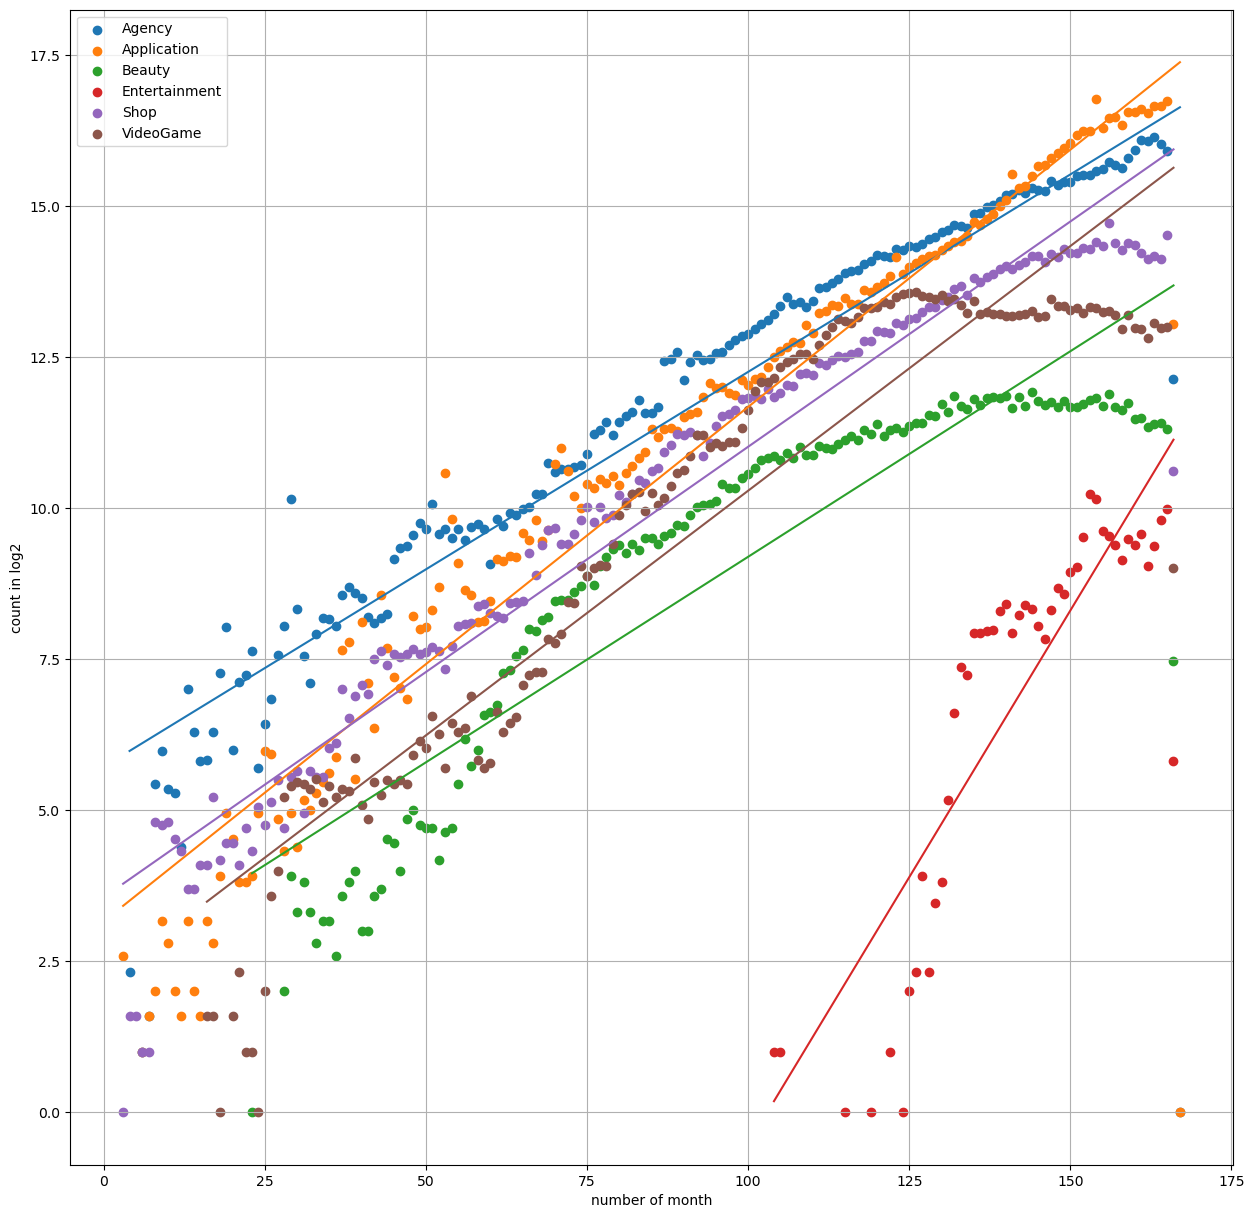

In [72]:
def evaluate_at(x, slope, intercept):
    """
    Evaluate the linear model at x.
    
    Args:
        x (float): The value to evaluate the model at.
        slope (float): The slope of the linear model.
        intercept (float): The intercept of the linear model.
        
    Returns:
        float: The value of the linear model at x.
    """
    return slope * x + intercept

# Group by category and plot the count per month
groups = df_count_month_cat.groupby('domain_categories')
fig, axs = plt.subplots(figsize = (15,15))
test_list = ['Agency', 'Application', 'Shop', "VideoGame", "Beauty" , "Entertainment"]
for name, group in groups:
    if name in test_list:
        group_reset = group.reset_index().sort_values(by=['month_cnt'])
        plt.scatter(group_reset.month_cnt.values, np.log2(group_reset["count"].values), label = name)
        slope, intercept, r, p, std_err = stats.linregress(group_reset.month_cnt.values,np.log2(group_reset["count"].values) )
        mymodel = list(map(lambda x: evaluate_at(x, slope, intercept), group_reset.month_cnt.values))
        plt.plot(group_reset.month_cnt.values, mymodel)
        
plt.ylabel('count in log2')
plt.xlabel('number of month')
plt.legend()
plt.savefig("evolution_month_app_entertainment.svg", format="svg")
plt.grid()
plt.show()

The logarithmic y-axis plot above show the number of video published per sponsored categories through months from the beginning of Youtube to 2019. Application, Agency, Beauty, Shop and Video Game are the categories that sponsor the most through the years. The slope from the linear interpolation gives us the exponantial growth of each sponsored categories and we can see that Application overtake Agency after the 129th month. On the other hand, Entertainment sponsor category appears lately on Youtube but its expansion have high growing growth by looking its slope that is higher than the other categories showed before.

The drop at the end is only due to the termination of our dataset, otherwise we observe an exponential growth for each categories which seems consistent with the fact that Youtube has seen an exponential increase of its use across the time.


In [26]:
test_list = ['Agency', 'Application', 'Shop', "VideoGame", "Beauty"]
slope_intercept_cat = {}
for name, group in groups:
    group_reset = group.reset_index().sort_values(by=['month_cnt'])
    slope, intercept, r, p, std_err = stats.linregress(group_reset.month_cnt.values,np.log2(group_reset["count"].values))
    mymodel = list(map(lambda x: evaluate_at(x, slope, intercept), group_reset.month_cnt.values))
    values_lin = { name : {
        "slope" : slope,
        "intercept": intercept
        }
    }

    slope_intercept_cat.update(values_lin)


In [30]:
def intersect_point(slope1, inter1, slope2, inter2):
    return (inter2- inter1)/(slope1 -  slope2)

month_intersection_agency_application = intersect_point(slope_intercept_cat.get("Agency").get("slope"),slope_intercept_cat\
    .get("Agency").get("intercept"),slope_intercept_cat.get("Application")\
        .get("slope"),slope_intercept_cat.get("Application").get("intercept"))
print("Agency video overtake Application video per month from ", int(month_intersection_agency_application),"th")

Agency video overtake Application video per month from  129 th


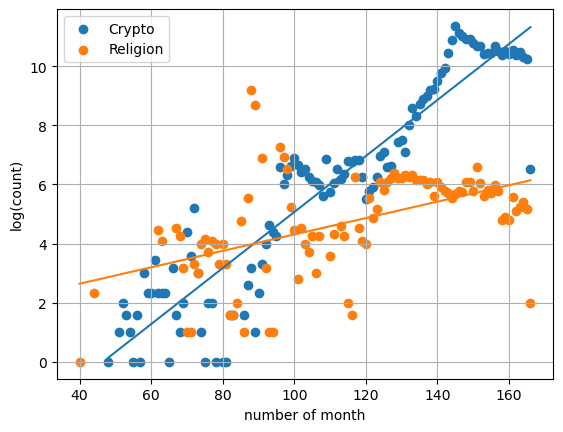

In [74]:
groups = df_count_month_cat.groupby('domain_categories')
fig, axs = plt.subplots()
test_list = ["Religion", "Crypto"]
for name, group in groups:
    if name in test_list:
        group_reset = group.reset_index().sort_values(by=['month_cnt'])
        plt.scatter(group_reset.month_cnt.values, np.log2(group_reset["count"].values), label = name)
        slope, intercept, r, p, std_err = stats.linregress(group_reset.month_cnt.values,np.log2(group_reset["count"].values))
        mymodel = list(map(lambda x: evaluate_at(x, slope, intercept), group_reset.month_cnt.values))
        plt.plot(group_reset.month_cnt.values, mymodel)

plt.ylabel('log(count)')
plt.xlabel('number of month')
plt.savefig("evolution_month_religion_crypto.svg", format="svg")
plt.legend()
plt.grid()
plt.show()

We observe for the "Crypto" category a big net increase in it's $log_2$ count across the span of life of Youtube, which is translated by it's bigger slope on the graph compare to that of the "Religion" category; which although we can clearly see that its growing, it's showing us a more modest growth.

Bootstrap for each categories domain

In [14]:
from tqdm import tqdm
def bootstrap(df, column, n_bootstrap=1000, alpha=0.05):
    # Get distribution values
    values = df.select(column).rdd.flatMap(lambda x: x).collect()
    values_list = []
    values = [x for x in values if x is not None]
    n_samples = len(values)
    for i in tqdm(range(n_bootstrap)):
        values_list.append(np.mean(np.random.choice(values, n_samples, replace=True)))

    # GET CI
    values_list.sort()
    lower = int(n_bootstrap * alpha / 2)
    upper = int(n_bootstrap * (1 - alpha / 2))
    return values_list, values_list[lower], values_list[upper]

In [34]:
categories_arr = np.unique(df_count_month_cat.domain_categories)

n_bootstrap = 1000
dict_category_bootstrap = {}
for category in categories_arr:
    category_df = explode_cat.filter(explode_cat.domain_categories == category)
    bootstrap_cat, ci_cat_lower, ci_cat_upper = bootstrap(category_df, 'month_cnt', n_bootstrap=n_bootstrap)
    category_dict = {
        category: {
        'values': bootstrap_cat,
        'ci_lower': ci_cat_lower,
        'ci_upper': ci_cat_upper
        }
    }
    dict_category_bootstrap.update(category_dict)

    

100%|██████████| 1000/1000 [00:01<00:00, 629.73it/s]


# --------------Parenthese bug-----DEBUT----------

In [35]:
dict_category_bootstrap.keys()


dict_keys(['Vehicle', 'VideoGame', 'YCW'])

In [36]:
import json

with open('dict_category_part3.json', 'w') as fp:
    json.dump(dict_category_bootstrap, fp)

In [54]:
with open('dict_category_part1.json') as f:
   dict_category_part1= json.load(f)

with open('dict_category_part2.json') as f:
   dict_category_part2= json.load(f)

with open('dict_category_part3.json') as f:
   dict_category_part3= json.load(f)



In [55]:
boot_final= dict_category_part1
boot_final.update(dict_category_part2)
boot_final.update(dict_category_part3)
boot_final.keys()

dict_keys(['Agency', 'Application', 'Beauty', 'Book', 'Crypto', 'Education', 'Entertainment', 'Fashion', 'Finance', 'FoodDrink', 'Media', 'Medical', 'Music', 'Photo', 'RealEstate', 'Religion', 'Service', 'Shop', 'Shorten', 'SocialMedia', 'Sport', 'Streaming', 'Technology', 'Travel', 'Vehicle', 'VideoGame', 'YCW'])

In [56]:
with open('dict_category_bootstrap_all.json', 'w') as fp:
    json.dump(boot_final, fp)

# ----------------------Parenthese bug--------------FIN---------------------------

In [57]:

with open('dict_category_bootstrap_all.json') as f:
   dict_category_bootstrap= json.load(f)



In [58]:
mean_categories_bootstrap = {}
for i, category in enumerate(dict_category_bootstrap):
    tmp ={category :  np.mean(dict_category_bootstrap.get(category).get("values"))}
    mean_categories_bootstrap.update(tmp)
    
    
mean_categories_bootstrap
order_mean_categories = {k: v for k, v in sorted(mean_categories_bootstrap.items(), key=lambda item: item[1])}

In [83]:
import pandas as pd
order_mean_categories
table_mean_order_boots = pd.DataFrame.from_dict({k: [v] for k, v in order_mean_categories.items()},orient='index')
table_mean_order_boots

,0
Religion,118.697421
Vehicle,120.951622
YCW,125.885751
RealEstate,126.289829
Sport,127.594505
Streaming,129.657438
Beauty,129.689410
Technology,130.574327
Book,130.590772
VideoGame,131.526074


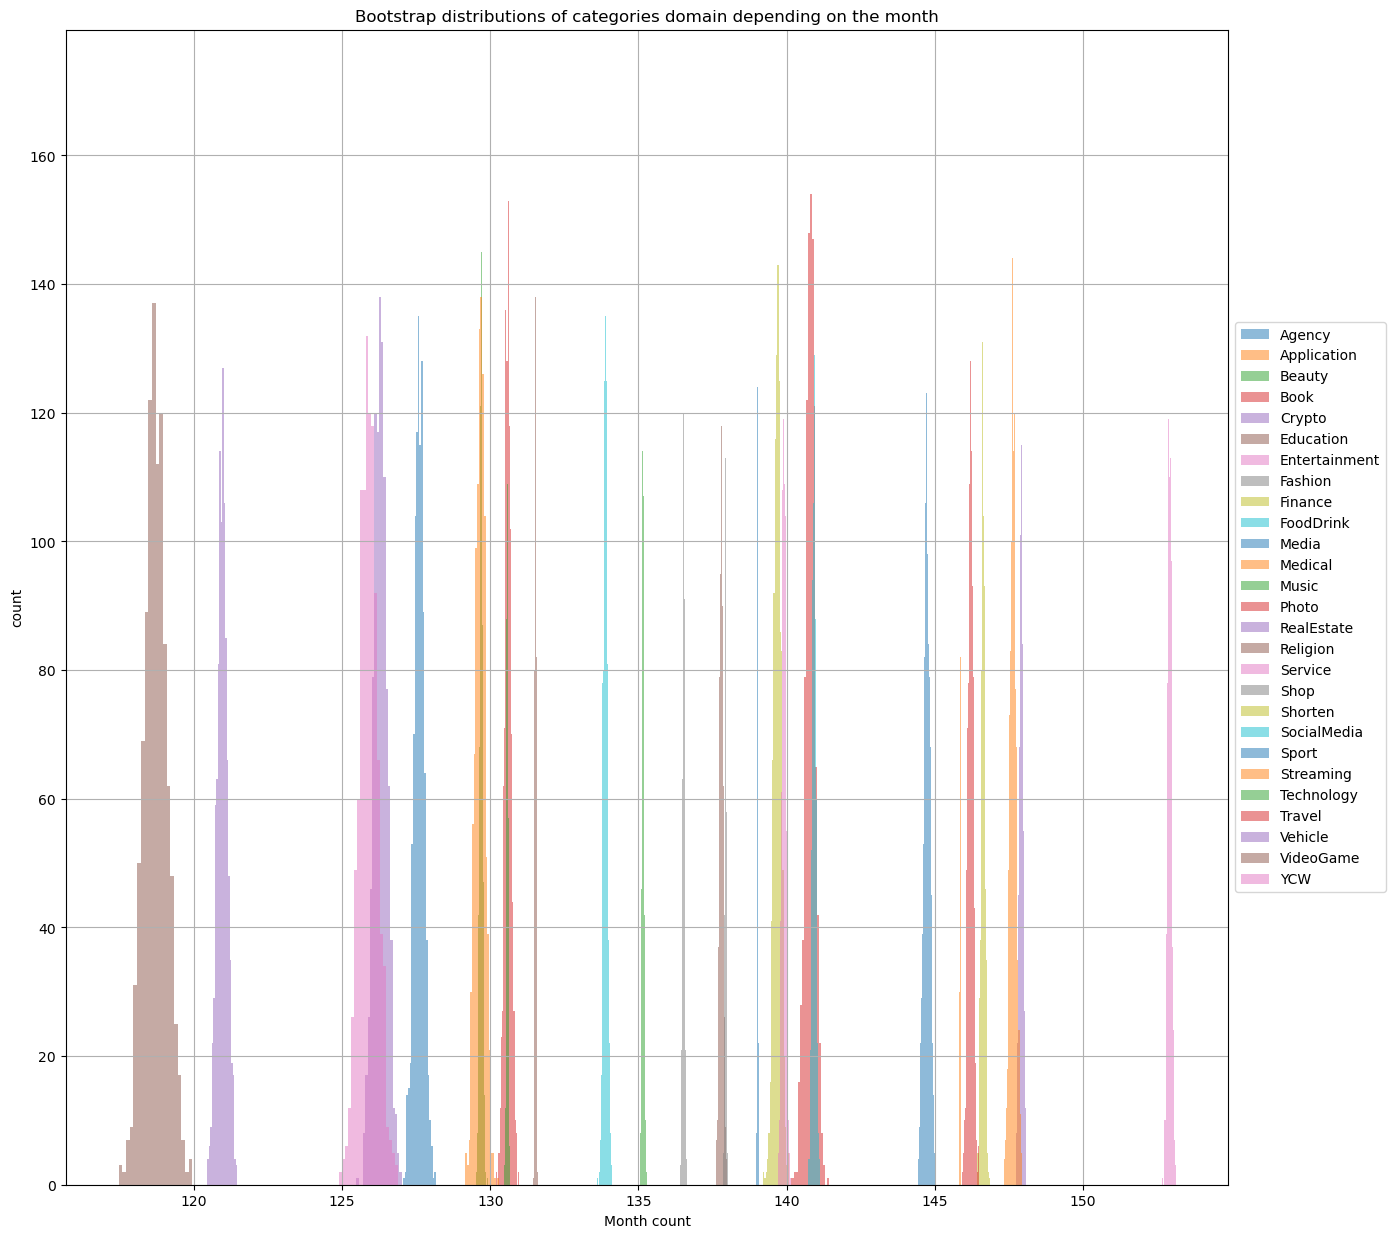

In [62]:
import matplotlib.pyplot as plt
# plot histograms
fig, ax = plt.subplots(figsize=(15, 15))
for i, category in enumerate(dict_category_bootstrap):
    ax.hist(dict_category_bootstrap[category]['values'], bins=20, alpha=0.5, label=category)

ax.set_title('Bootstrap distributions of categories domain depending on the month')
plt.xlabel("Month count")
plt.ylabel("count")
plt.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

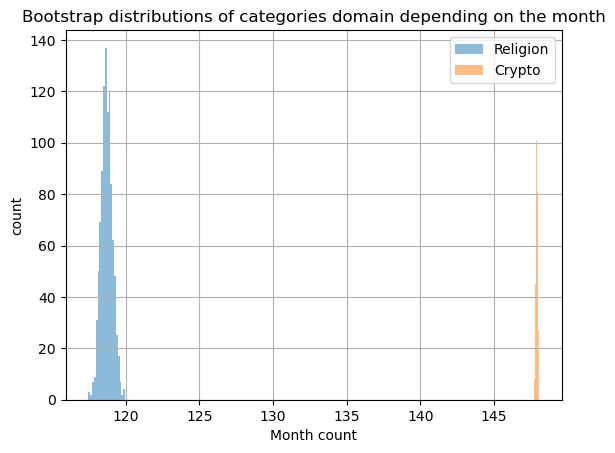

In [68]:
category_list_1 = ["Religion", "Crypto"]
# plot histograms
fig, ax = plt.subplots()
for category in category_list_1:
    ax.hist(dict_category_bootstrap[category]['values'], bins=20, alpha=0.5, label=category)
ax.set_title('Bootstrap distributions of categories domain depending on the month')
plt.xlabel("Month count")
plt.ylabel("count")
plt.grid()
ax.legend()
plt.savefig("mean_bootstrap_religion_crypto.svg", format="svg")
plt.show()

By doing bootstrap of 1000 samples, we can determine a normal distribtution for each of the sponsor categories. The mean of each categories is located between de 119th and 152th month. 
What is the parameter that induce a change in the mean distribution ? To answer to this question, we need to analyze the number of video publish for each sponsor categories through months.

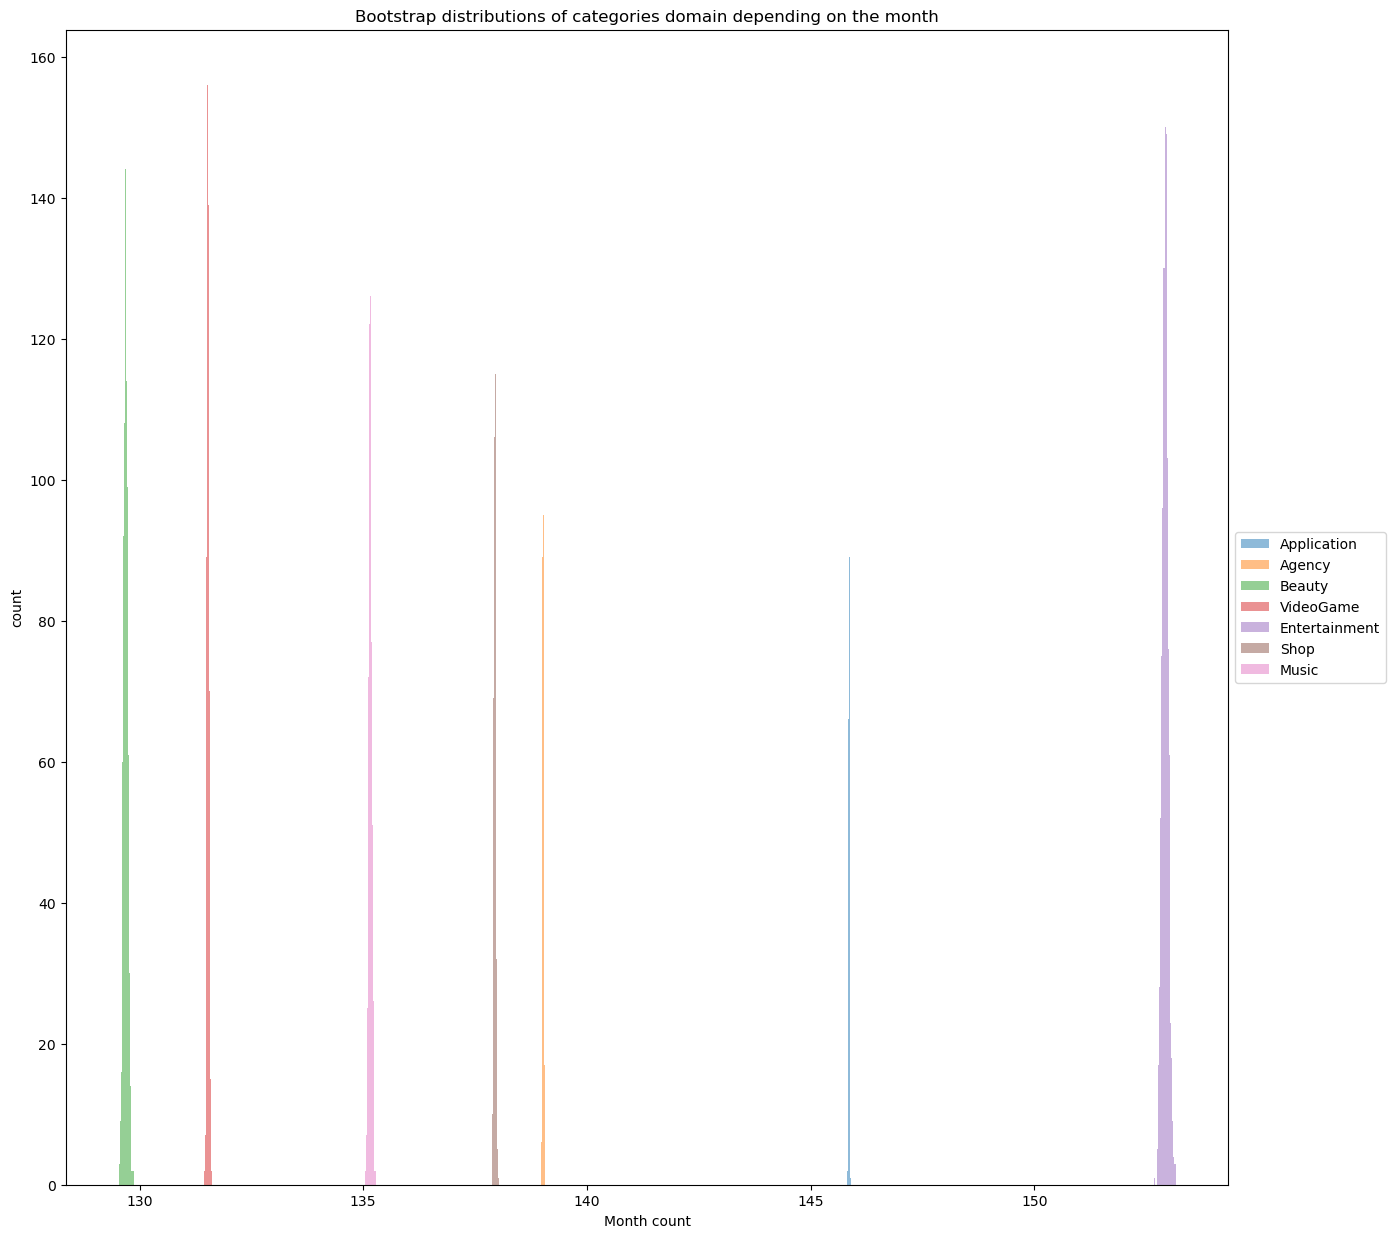

In [92]:
category_list_1 = ['Application', 'Agency', 'Beauty', 'VideoGame','Entertainment','Shop', 'Music']
# plot histograms
fig, ax = plt.subplots(figsize=(15, 15))
for category in category_list_1:
    ax.hist(dict_category_bootstrap[category]['values'], bins=20, alpha=0.5, label=category)
    #ax.axvline(dict_category_bootstrap[category]['ci_lower'], color='red', linestyle='dashed', linewidth=1)
    #ax.axvline(dict_category_bootstrap[category]['ci_upper'], color='red', linestyle='dashed', linewidth=1)
ax.set_title('Bootstrap distributions of categories domain depending on the month')
plt.xlabel("Month count")
plt.ylabel("count")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

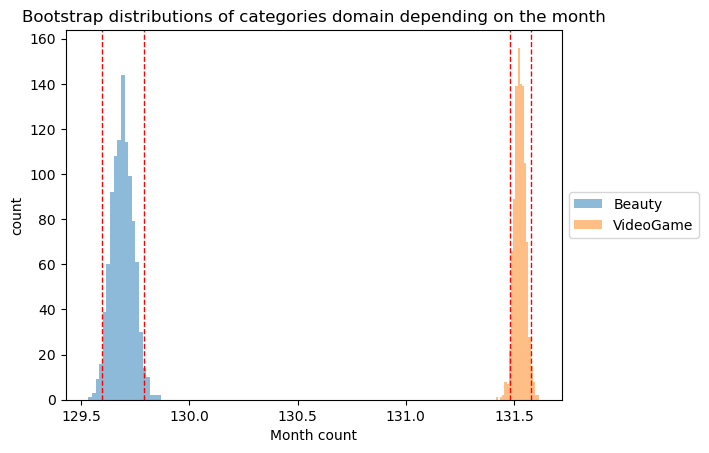

In [94]:
category_list_videogame_beauty = ['Beauty', 'VideoGame']
# plot histograms
fig, ax = plt.subplots()
for category in category_list_videogame_beauty:
    ax.hist(dict_category_bootstrap[category]['values'], bins=20, alpha=0.5, label=category)
    ax.axvline(dict_category_bootstrap[category]['ci_lower'], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(dict_category_bootstrap[category]['ci_upper'], color='red', linestyle='dashed', linewidth=1)
    
ax.set_title('Bootstrap distributions of categories domain depending on the month')
plt.xlabel("Month count")
plt.ylabel("count")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Text(0, 0.5, 'count')

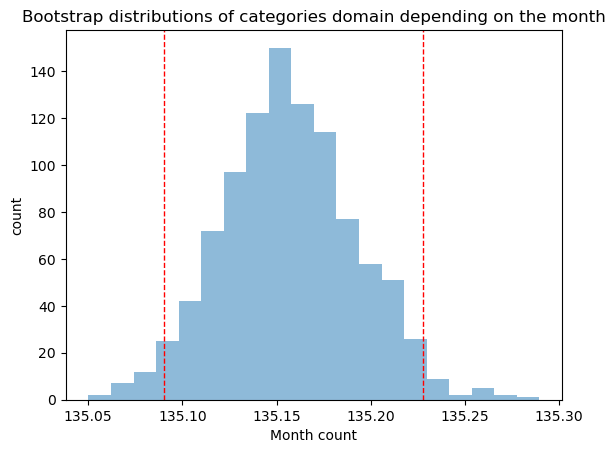

In [95]:
fig, ax = plt.subplots()
ax.hist(dict_category_bootstrap['Music']['values'], bins=20, alpha=0.5, label=category)
ax.axvline(dict_category_bootstrap['Music']['ci_lower'], color='red', linestyle='dashed', linewidth=1)
ax.axvline(dict_category_bootstrap['Music']['ci_upper'], color='red', linestyle='dashed', linewidth=1)

ax.set_title('Bootstrap distributions of categories domain depending on the month')
plt.xlabel("Month count")
plt.ylabel("count")

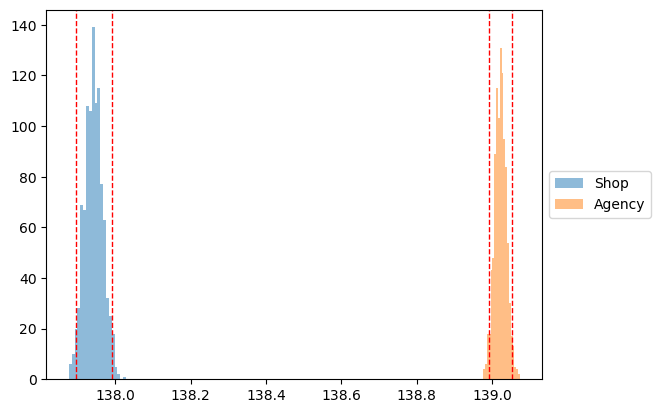

In [84]:
category_list_shop_agency = ['Shop', 'Agency']
fig, ax = plt.subplots()
for category in category_list_shop_agency:
    ax.hist(dict_category_bootstrap[category]['values'], bins=20, alpha=0.5, label=category)
    ax.axvline(dict_category_bootstrap[category]['ci_lower'], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(dict_category_bootstrap[category]['ci_upper'], color='red', linestyle='dashed', linewidth=1)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Explode by domains and filter app.google, rstyle.me and unionforgamers.com

In [96]:
explode_domain = fusion_df.withColumn("domain", f.explode("domains")).drop('domains')
keep_google = explode_domain.filter(explode_domain.domain == 'play.google.com')
count_month_google = keep_google.groupby('month_cnt').count()

In [97]:
keep_rstyle = explode_domain.filter(explode_domain.domain == 'rstyle.me')
count_month_rstyle = keep_rstyle.groupby('month_cnt').count()

In [98]:
keep_union_gamer = explode_domain.filter(explode_domain.domain == 'unionforgamers.com')
count_month_union_gamer = keep_union_gamer.groupby('month_cnt').count()

--> convert google videos pyspark into pandas

In [99]:
df_google = count_month_google.toPandas()
df_google

,month_cnt,count
0,148,44601
1,31,17
2,137,27986
3,85,1712
4,65,585
...,...,...
157,12,3
158,16,3
159,15,3
160,14,2


In [17]:
df_rstyle = count_month_rstyle.toPandas()
df_rstyle

,month_cnt,count
0,148,29839
1,137,20072
2,85,286
3,133,16717
4,78,140
...,...,...
116,67,14
117,46,6
118,54,1
119,39,3


In [20]:
df_union = count_month_union_gamer.toPandas()
df_union

,month_cnt,count
0,148,2544
1,137,3730
2,85,19
3,133,3256
4,78,57
...,...,...
104,65,1
105,73,9
106,55,1
107,60,2


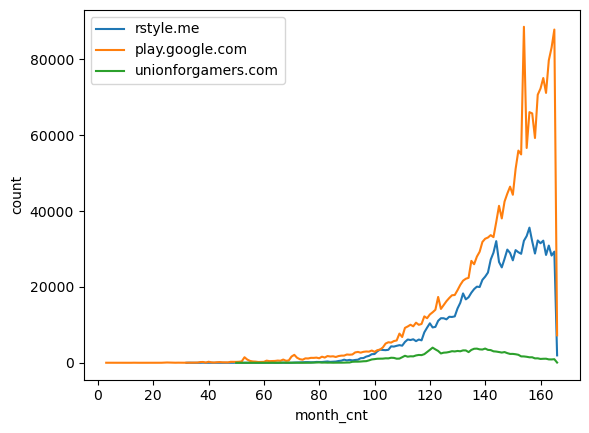

<Figure size 1500x1500 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
sns.lineplot(x="month_cnt", y="count", data=df_rstyle, label = 'rstyle.me')
sns.lineplot(x="month_cnt", y="count", data=df_google, label = 'play.google.com')
sns.lineplot(x="month_cnt", y="count", data=df_union, label = 'unionforgamers.com')
plt.figure(figsize=(15,15))
plt.yscale('log')
plt.show()